In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os import listdir, makedirs
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, regularizers, losses
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.preprocessing import image
from keras.datasets import mnist
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
print(os.listdir("/home/yaagocruuz/Documentos/git/Topicos3/Trabalho Final/"))

['retrain.py', '.ipynb_checkpoints', 'sem_finetuning.ipynb', 'dataset', 'Trabalho Final.ipynb']


In [20]:
RESOLUTION = 139
BATCH_SIZE = 64


data_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,
                                  horizontal_flip=True, validation_split=0.20)

train_generator = data_datagen.flow_from_directory(
        "dataset/",
        classes=['Caroline_Kennedy', 'Edward_Moore_Kennedy', 'Eunice_Kennedy_Shriver', 'Jacqueline_Lee_Bouvier', 
                 'Jean_Kennedy Smith', 'John_F_Kennedy_Jr', 'John_Fitzgerald_Kennedy', 
                 'Joseph_P_Kennedy_Sr', 'Robert_Francis_Kennedy', 'Rose_Elizabeth_Fitzgerald', 
                 'Rosemary_Kenndy', 'Outros'],
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training")

val_generator = data_datagen.flow_from_directory(
        "dataset/",
        classes=['Caroline_Kennedy', 'Edward_Moore_Kennedy', 'Eunice_Kennedy_Shriver', 'Jacqueline_Lee_Bouvier', 
                 'Jean_Kennedy Smith', 'John_F_Kennedy_Jr', 'John_Fitzgerald_Kennedy', 
                 'Joseph_P_Kennedy_Sr', 'Robert_Francis_Kennedy', 'Rose_Elizabeth_Fitzgerald', 
                 'Rosemary_Kenndy', 'Outros'],
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation")

Found 499 images belonging to 12 classes.
Found 120 images belonging to 12 classes.


In [21]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139,139,3))

In [7]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(12, activation='softmax')(x)

In [8]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [12]:
# train the model on the new data for a few epochs
model.fit_generator(generator=train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
18/18 [==============================] - 38s 2s/step - loss: 5.7923 - acc: 0.1954 - val_loss: 5.7968 - val_acc: 0.1515
Epoch 2/30
18/18 [==============================] - 34s 2s/step - loss: 2.5709 - acc: 0.2875 - val_loss: 9.2205 - val_acc: 0.1515
Epoch 3/30
18/18 [==============================] - 36s 2s/step - loss: 2.3718 - acc: 0.3493 - val_loss: 3.5582 - val_acc: 0.3333
Epoch 4/30
18/18 [==============================] - 36s 2s/step - loss: 1.9267 - acc: 0.4300 - val_loss: 6.6211 - val_acc: 0.1818
Epoch 5/30
18/18 [==============================] - 36s 2s/step - loss: 1.9524 - acc: 0.4483 - val_loss: 4.6474 - val_acc: 0.3182
Epoch 6/30
18/18 [==============================] - 36s 2s/step - loss: 1.5286 - acc: 0.4838 - val_loss: 4.3299 - val_acc: 0.3485
Epoch 7/30
18/18 [==============================] - 36s 2s/step - loss: 1.5345 - acc: 0.5621 - val_loss: 4.5974 - val_acc: 0.4545
Epoch 8/30
18/18 [==============================] - 36s 2s/step - loss: 1.2701 - acc: 0.60

In [13]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [14]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [17]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(generator=train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
18/18 [==============================] - 47s 3s/step - loss: 0.5259 - acc: 0.8410 - val_loss: 6.7174 - val_acc: 0.3788
Epoch 2/30
18/18 [==============================] - 40s 2s/step - loss: 0.4366 - acc: 0.8688 - val_loss: 6.1634 - val_acc: 0.3333
Epoch 3/30
18/18 [==============================] - 41s 2s/step - loss: 0.3165 - acc: 0.9140 - val_loss: 6.7094 - val_acc: 0.3485
Epoch 4/30
18/18 [==============================] - 42s 2s/step - loss: 0.3309 - acc: 0.9010 - val_loss: 6.6077 - val_acc: 0.4242
Epoch 5/30
18/18 [==============================] - 42s 2s/step - loss: 0.2985 - acc: 0.9193 - val_loss: 6.3123 - val_acc: 0.3485
Epoch 6/30
18/18 [==============================] - 41s 2s/step - loss: 0.3142 - acc: 0.8941 - val_loss: 6.2788 - val_acc: 0.3485
Epoch 7/30
18/18 [==============================] - 41s 2s/step - loss: 0.3150 - acc: 0.8924 - val_loss: 6.1355 - val_acc: 0.3939
Epoch 8/30
18/18 [==============================] - 41s 2s/step - loss: 0.3226 - acc: 0.91

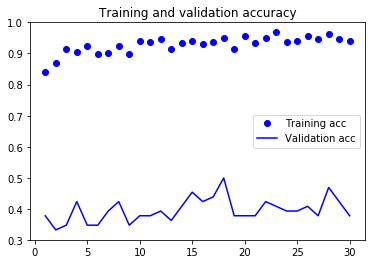

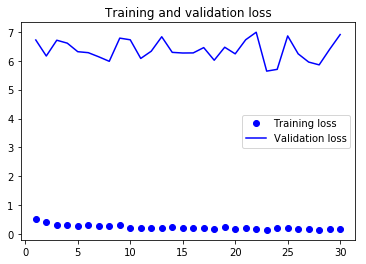

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()